In [1]:
%matplotlib inline
import re
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from spectrometer import FID1D, plot, process

Did not find any configuration file. Using defaults.


In [2]:
# Load raw *.fid data
fids: list[FID1D] = []
for file in Path("../data/20230822-105316-Water-1H-rabi-nutation").glob("*.fid"):
    fids.append(FID1D.from_file(file))

# Extract pulse lengths from metadata
pattern = r"length=(.*)us,delay="
pulse_lengths_us = [float(re.search(pattern, str(fid.pulse))[1]) for fid in fids]

# Sort data by pulse lengths
pulse_lengths_us, fids = zip(*sorted(zip(pulse_lengths_us, fids)))

Pulse length of 90-degree pulse candidate: 6.654060066740823
Pulse number: 17
Estimated phase offset: 14.64325000000002
Estimated Full Width at Half Maximum: 150.50464231340743 Hz
Estimated Full Width at Half Maximum in indexes: 8
Estimated peak location index: 4112


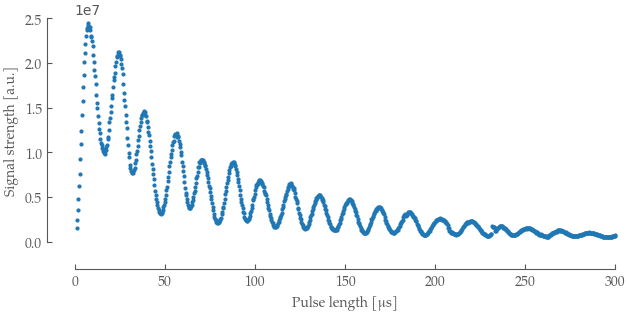

In [3]:
# Process
signal_strengths = []
for _i, fid in enumerate(fids):
    x, y = fid.simple_fft(phase_shift_kwargs=False)
    # TODO: Figure out why x is inverted?
    x = np.flip(x)
    y = np.flip(y)
    y = np.square(np.abs(y))
    integral = np.trapz(y)
    signal_strengths.append(integral)

# Estimate maximum signal strength pulse length
max_pulse_idx = int(np.argmax(signal_strengths))
median_max_pulse_idx = np.where(signal_strengths == np.percentile(signal_strengths[max_pulse_idx-5:max_pulse_idx+5], 50, method="closest_observation"))[0][0]  # 'median' picking closest on even array
print(f"Pulse length of 90-degree pulse candidate: {pulse_lengths_us[median_max_pulse_idx]}")
print(f"Pulse number: {median_max_pulse_idx}")

# Estimate zero-order phase correction
scale, fft, p0 = fids[median_max_pulse_idx].simple_fft()
print(f"Estimated phase offset: {p0}")

# Estimate peak width
fit_lorentz = process.fit_lorentz(scale, fft.real)
print(f"Estimated Full Width at Half Maximum: {fit_lorentz['gamma'] * 2} Hz")
peak_idx = np.argmax(fft)
peak_width_idx = int(np.ceil((fit_lorentz["gamma"] * 2) / (scale[0] - scale[1]))) * 2
print(f"Estimated Full Width at Half Maximum in indexes: {peak_width_idx}")
print(f"Estimated peak location index: {peak_idx}")

# Plot raw data
# TODO: Why this shape?
# => composite pulses? very inhomogenous, sinc excites less at edges of peak?
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    pulse_lengths_us,
    np.real(signal_strengths),
    linestyle="",
    marker="o",
    markersize=2,
)
axes.set_ylabel("Signal strength [a.u.]")
axes.set_xlabel("Pulse length [μs]")

plot.format_axes(axes)

In [4]:
# Process rabi nutation
signal_strengths = []
for _i, fid in enumerate(fids):
    x, y = fid.simple_fft(phase_shift_kwargs={"p0": p0})
    # TODO: Figure out why x is inverted
    x = np.flip(x[peak_idx - peak_width_idx : peak_idx + peak_width_idx])
    y = np.flip(y[peak_idx - peak_width_idx : peak_idx + peak_width_idx])
    integral = np.trapz(y)
    signal_strengths.append(integral)

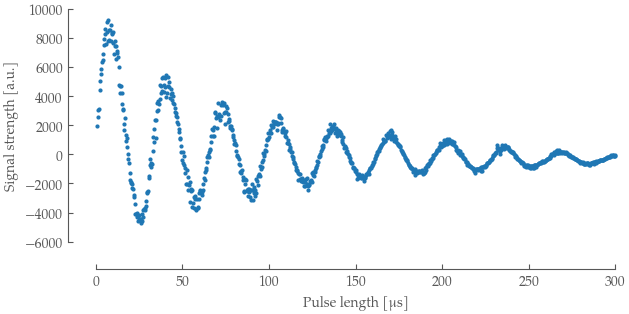

In [5]:
# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    pulse_lengths_us,
    np.real(signal_strengths),
    linestyle="",
    marker="o",
    markersize=2,
)
axes.set_ylabel("Signal strength [a.u.]")
axes.set_xlabel("Pulse length [μs]")

plot.format_axes(axes)

fig.savefig("rabi_nutation_raw.pdf")

Amplitude: 8155.044424269405
Frequency: 0.030944141718050044 MHz
Period: 32.31629460308118 us
Offset: 97.9789170006747
Phase: -0.16314213919150206
Lambda: 0.012152153169420397 MHz
'T2*': 82.2899436880366 us


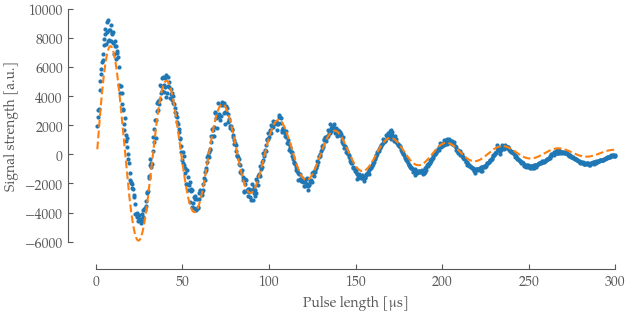

In [6]:
# Try to plot simple least squares fit
fit = process.fit_decaying_sinusoid(pulse_lengths_us, np.real(signal_strengths))
pulse_lengths_us_fine = np.linspace(
    pulse_lengths_us[0], pulse_lengths_us[-1], len(pulse_lengths_us) * 10
)
print(f"Amplitude: {fit['amplitude']}")
print(f"Frequency: {fit['frequency']} MHz")
print(f"Period: {1/fit['frequency']} us")
print(f"Offset: {fit['offset']}")
print(f"Phase: {fit['phase']}")
print(f"Lambda: {fit['lambda']} MHz")
print(f"'T2*': {1/fit['lambda']} us")

# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    pulse_lengths_us,
    np.real(signal_strengths),
    linestyle="",
    marker="o",
    markersize=2,
)
axes.set_ylabel("Signal strength [a.u.]")
axes.set_xlabel("Pulse length [μs]")

plot.format_axes(axes)
axes.plot(
    pulse_lengths_us_fine,
    fit["function"](pulse_lengths_us_fine),
    linestyle="--",
)

# Save plot
fig.savefig("rabi_nutation_fit.pdf")

2.9955506117908786
900
-0.17247465
1177.224


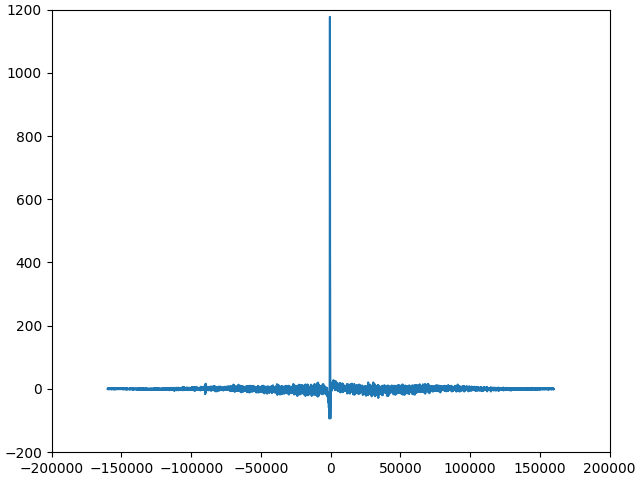

In [7]:
idx = 6
pulse_length, fid = pulse_lengths_us[idx], fids[idx]

fig, axes = plot.subplots()
scale, fft, p0 = fid.simple_fft()
axes.plot(scale, fft.real)
print(pulse_length)
print(len(pulse_lengths_us))
print(np.median(fft.real))
print(np.max(np.abs(fft.real)))

/home/mstabel/Projects/nmr-spectrometer/software/spectrometer/.venv/lib64/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


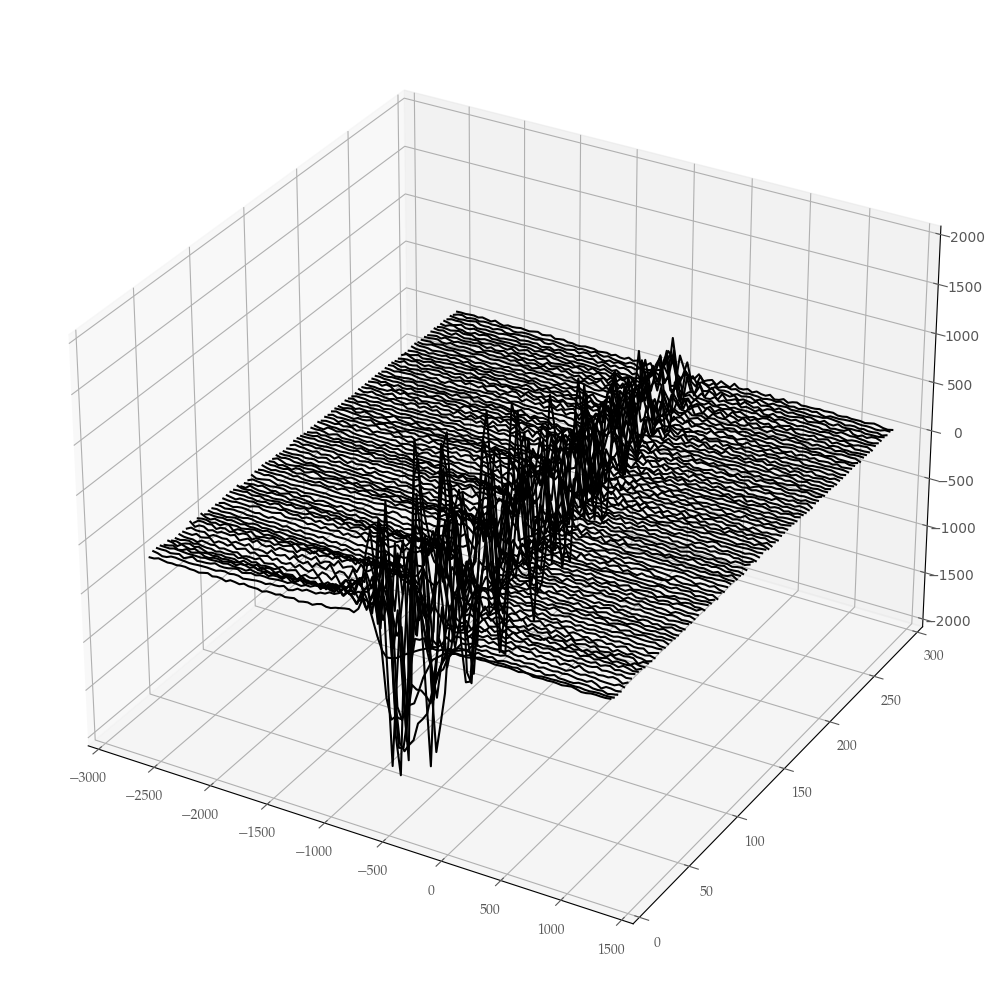

In [8]:
# Raw plot
fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot(projection="3d")
for pulse_length, fid in list(zip(pulse_lengths_us, fids))[::10]:
    scale, fft = fid.simple_fft(
        phase_shift_kwargs={"p0": -110}  # No phase correction
    )  # phase_shift_kwargs={"p0": -110})  # No phase correction
    scale = scale[peak_idx - 50 : peak_idx + 50]
    fft = fft[peak_idx - 50 : peak_idx + 50]
    axes.plot(np.flip(scale), np.flip(fft), zs=pulse_length, zdir="y", color="k")

    axes.spines[["top", "right"]].set_visible(False)
fig.tight_layout()
plot.format_axes(axes)